# HSE 2023: Mathematical Methods for Data Analysis

## Homework 3

**Warning 1**: some problems require (especially the lemmatization part) significant amount of time, so **it is better to start early (!)**

**Warning 2**: it is critical to describe and explain what you are doing and why, use markdown cells

In [ ]:
from typing import Tuple, List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
%matplotlib inline

sns.set(style="darkgrid")

## PART 1: Logit model

We consider a binary classification problem. For prediction, we would like to use a logistic regression model. For regularization we add a combination of the $l_2$ and $l_1$ penalties (Elastic Net).

Each object in the training dataset is indexed with $i$ and described by pair: features $x_i\in\mathbb{R}^{K}$ and binary labels $y_i$. The model parametrized with bias $w_0\in\mathbb{R}$ and weights $w\in\mathbb{R}^K$. Note: Bias is included in $w$ vector

The optimization problem with respect to the $w_0, w$ is the following (Logistic loss with Elastic Net regularizers):

$$L(w) = \sum_{i=1}^{N} -y_i \log{\sigma{(w^\top x_i)}} - (1 - y_i) \log{(1 - \sigma{(w^\top x_i)})} + \gamma \|w\|_1 + \beta \|w\|_2^2$$

#### 1. [0.5 points]  Find the gradient of the Elastic Net loss and write its formulas (better in latex format). Remember what derivative sigmoid has (gradient in fact is a lot simpler than you may get using automatic tools like sympy, matlab or whatever)

Поскольку сдвиг $w_0$ включен в веса, то чтобы посчитать градиент достаточно взять производную функции потерь по $w$.
Сразу заменим сумму на матричный вид и немного преобразуем выражение:
$$L(w) = -y^\top \log{\sigma{(xw)}} - (1 - y)^\top \log{(1 - \sigma{(xw)})}  + \gamma \|w\|_1 + \beta \|w\|_2^2$$

Для начала рассмотрим какими будут производные слагаемых регулиризаторов:
$$\|w\|_1 = \sum_{j=1}^{N}|w_j|$$
$$\|w\|_2 = \sqrt{\sum_{j=1}^{N}w_j^2}, следовательно \|w\|_2^2 = \sum_{j=1}^{N}w_j^2$$

Тогда их производные будут:
$$\frac{d\gamma\|w\|_1}{dw} = \gamma sign(w)$$
$$\frac{d\beta\|w\|_2^2}{dw} = 2\beta w$$

Теперь выразим значение всего градиента, принимая во внимание производную сигмоиды и правило производной сложной функции:
$$\nabla L(w) = \frac{dL}{dw} = X^\top(\sigma(Xw) - y) + \gamma sign(w) + 2\beta w$$



##### Put your markdown formulas here

#### 2. [0.25 points] Implement the Elastic Net loss (as a function)

In [ ]:
def sigmoid(x):
  return 1 / (1 + np.exp(-x))

In [ ]:
def loss(X, y, w: List[float], gamma=1., beta=1.) -> float:
    y_pred = np.dot(X, w)
    sigma = sigmoid(y_pred)
    l1_reg = gamma * np.linalg.norm(w, 1)
    l2_reg = beta * np.linalg.norm(w, 2)**2
    return np.sum(-y * np.log(sigma) - (1 - y) * np.log(1 - sigma)) + l1_reg + l2_reg


#### 3. [0.25 points] Implement the gradient (as a function)

In [ ]:
def get_grad(X, y, w: List[float], gamma=1., beta=1.) -> Tuple[List[float], float]:
    y_pred = np.dot(X, w)
    sigma = sigmoid(y_pred)
    l1_reg = gamma * np.sign(w)
    l2_reg = 2 * beta * w
    grad_w  = np.dot(X.T, sigma - y) + l1_reg + l2_reg
    return grad_w

#### Check yourself

In [ ]:
np.random.seed(42)
X = np.random.multivariate_normal(np.arange(5), np.eye(5), size=10)
X = np.c_[np.ones(X.shape[0]), X]
y = np.random.binomial(1, 0.42, size=10)
w = np.random.normal(size=5 + 1)
grad_w = get_grad(X, y, w)
assert(np.allclose(grad_w,
                   [-3.99447493, -1.84786723,  0.64520104,  1.67059973, -5.03858487, -5.21496336],
                   rtol=1e-2)
)

####  4. [1 point]  Implement gradient descent which works for both tol level and max_iter stop criteria and plot the decision boundary of the result

The template provides basic sklearn API class. You are free to modify it in any convenient way.

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin

In [ ]:
class Logit(BaseEstimator, ClassifierMixin):
    def __init__(self, beta=1.0, gamma=1.0, lr=1e-3, tolerance=1e-2, max_iter=1000, random_state=42):
        self.beta = beta
        self.gamma = gamma
        self.tolerance= tolerance
        self.max_iter= max_iter
        self.lr = lr
        self.random_state = random_state
        self.w = None
        self.loss_history = []
        # you may additional properties if you wish

    def fit(self, X, y):
        # add weights and bias and optimize Elastic Net loss over (X,y) dataset
        # save history of optimization steps
        np.random.seed(self.random_state)
        # adding bias
        X = np.c_[np.ones(X.shape[0]), X]
        # initialize weight with random values
        self.w = np.random.normal(size=X.shape[1])
        for iteration in range(self.max_iter):
          gradient = get_grad(X, y, self.w, self.gamma, self.beta)
          self.w -= self.lr * gradient
          # saving the value of the loss function to history
          self.loss_history.append(loss(X, y, self.w, self.gamma, self.beta))
          # abort by tolerance
          if len(self.loss_history) > 1 and np.abs(self.loss_history[-1] - self.loss_history[-2]) < self.tolerance:
                break

        return self

    def predict(self, X):
        # return vector of predicted labels (0 or 1) for each object from X
        if self.w is None:
            raise Exception('Not trained yet')
        # adding bias
        X = np.c_[np.ones(X.shape[0]), X]
        return np.round(sigmoid(np.dot(X, self.w) + self.beta))

    def predict_proba(self, X):
      # return vector of probabilities for each object from X
        X = np.c_[np.ones(X.shape[0]), X]
        return np.array([1 / (1 + np.exp(np.dot(X, self.w))),\
                         1 / (1 + np.exp(-np.dot(X, self.w)))])

In [ ]:
# sample data to test your model
from sklearn.datasets import make_classification
X, y = make_classification(n_samples=180, n_features=2, n_redundant=0, n_informative=2,
                               random_state=42, n_clusters_per_class=1)

In [ ]:
# a function to plot the decision boundary
def plot_decision_boundary(model, X, y):
    fig = plt.figure()
    X1min, X2min = X.min(axis=0)
    X1max, X2max = X.max(axis=0)
    x1, x2 = np.meshgrid(np.linspace(X1min, X1max, 200),
                         np.linspace(X2min, X2max, 200))
    ypred = model.predict(np.c_[x1.ravel(), x2.ravel()])
    ypred = ypred.reshape(x1.shape)

    plt.contourf(x1, x2, ypred, alpha=.4)
    plt.scatter(X[:,0], X[:,1], c=y)

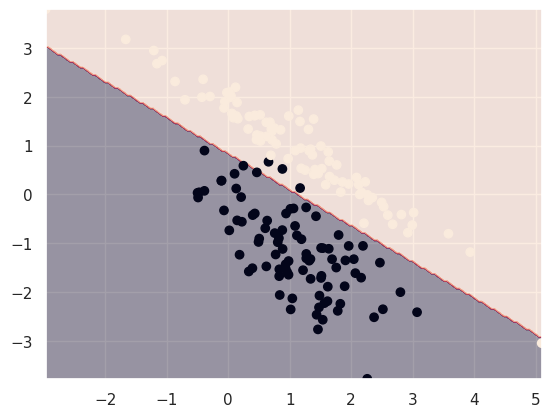

In [ ]:
model = Logit(0, 0)
model.fit(X, y)
plot_decision_boundary(model, X, y)

### Анализ полученных результатов:

На графике видно, что decision boundary подобрана хорошо, разделяя выборку на две части оставляя лишь некоторые выбросы в другом классе.

#### 5. [0.25 points] Plot loss diagram for the model, i.e. show the dependence of the loss function from the gradient descent steps

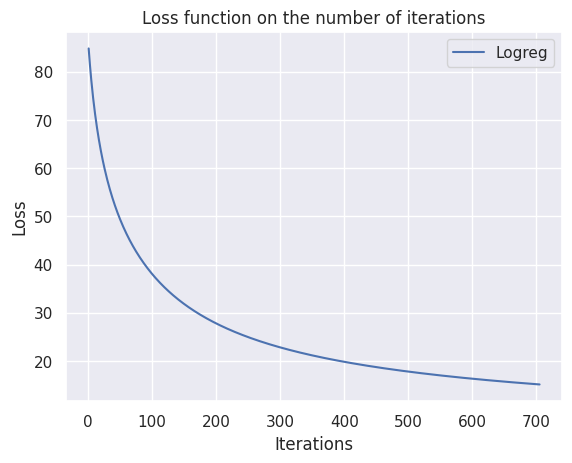

In [ ]:
plt.plot(range(1, len(model.loss_history) + 1), model.loss_history, label="Logreg")

plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Loss function on the number of iterations')
plt.legend()
plt.grid(True)

plt.show()

### Анализ полученных результатов:

График показывает планомерное снижение значений функции ошибки модели, прерывание происходит приблизительно на отметке 700 итераций, то есть можно сказать, что произошла остановка по tolerance.

## PART 2: Support Vector Machines

#### 6. [2 point] Using the same dataset, train SVM Classifier from Sklearn.
Investigate how different parameters influence the quality of the solution:
+ Try several kernels: Linear, Polynomial, RBF (and others if you wish). Some Kernels have hypermeters: don't forget to try different.
+ Regularization coefficient

Show how these parameters affect accuracy, roc_auc and f1 score.
Make plots for the dependencies between metrics and parameters.
Try to formulate conclusions from the observations. How sensitive are kernels to hyperparameters? How sensitive is a solution to the regularization? Which kernel is prone to overfitting?

{'linear': {'accuracy': [0.8888888888888888, 1.0, 1.0, 1.0, 1.0, 1.0], 'roc_auc': [0.05246913580246914, 1.0, 1.0, 1.0, 1.0, 1.0], 'f1_score': [0.8750000000000001, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'poly': {'accuracy': [0.6388888888888888, 1.0, 0.9722222222222222, 0.9722222222222222, 0.9722222222222222, 1.0], 'roc_auc': [0.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'f1_score': [0.4347826086956522, 1.0, 0.9714285714285714, 0.9714285714285714, 0.9714285714285714, 1.0]}, 'rbf': {'accuracy': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'roc_auc': [0.0, 0.3333333333333333, 1.0, 1.0, 1.0, 1.0], 'f1_score': [1.0, 1.0, 1.0, 1.0, 1.0, 1.0]}, 'sigmoid': {'accuracy': [0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8888888888888888, 0.8611111111111112, 0.7777777777777778], 'roc_auc': [0.030864197530864203, 0.9645061728395061, 1.0, 1.0, 0.9691358024691359, 0.8641975308641975], 'f1_score': [0.8750000000000001, 0.8750000000000001, 0.8750000000000001, 0.8750000000000001, 0.8387096774193548, 0.7333333333333334]}}


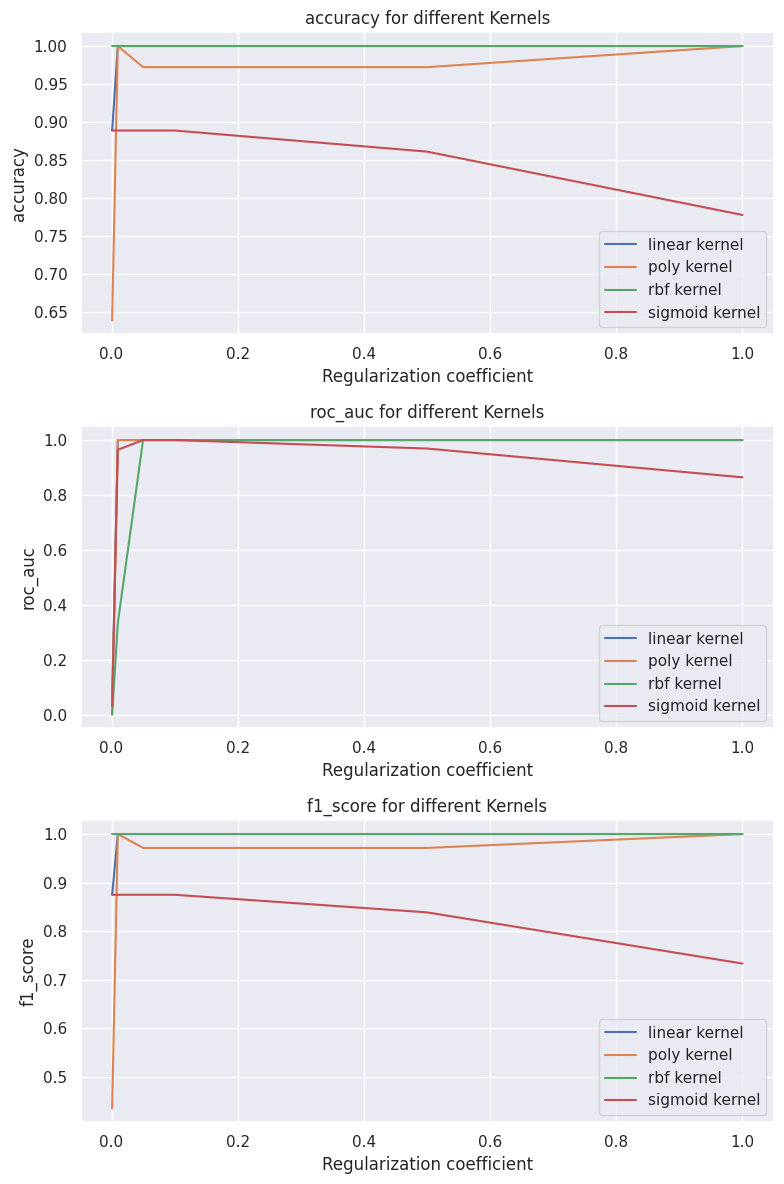

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define the parameter grid for each kernel
RC_list = [0.001, 0.01, 0.05, 0.1, 0.5, 1]

# Initialize empty dictionaries to store results
results = {'linear': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
           'poly': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
           'rbf': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
           'sigmoid': {'accuracy': [], 'roc_auc': [], 'f1_score': []},
}

# Iterate over kernels
for kernel in results.keys():
    for RC in RC_list:
      # Initialize SVM with the specific kernel
      svm = SVC(kernel=kernel, C=RC, probability=True, random_state=42)
      svm.fit(X_train, y_train)

      # Collect results
      y_pred = svm.predict(X_test)
      y_proba = svm.predict_proba(X_test)[:, 1]

      # Calculate metrics
      accuracy = accuracy_score(y_test, y_pred)
      roc_auc = roc_auc_score(y_test, y_proba)
      f1 = f1_score(y_test, y_pred)

      # Store results
      results[kernel]['accuracy'].append(accuracy)
      results[kernel]['roc_auc'].append(roc_auc)
      results[kernel]['f1_score'].append(f1)
print(results)
# Plot the results with line plots
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8, 12))
metrics = ['accuracy', 'roc_auc', 'f1_score']

for i, metric in enumerate(metrics):
    for kernel in results.keys():
        axes[i].plot(RC_list,
                     results[kernel][metric],
                     label=f'{kernel} kernel')

    axes[i].set_title(f'{metric} for different Kernels')
    axes[i].set_xlabel('Regularization coefficient')
    axes[i].set_ylabel(metric)
    axes[i].legend()

plt.tight_layout()
plt.show()


### Анализ полученных результатов
 В целом можно сказать, что слишком высокий коэффициент регуляризации не идет на пользу некоторым моделям. При больших значениях эффективность например модели с ядром poly так же на время ухудшается и лишь при максимальном значение вновь возвращается к 1. По полученным данным видно, что в общем хуже всего с задачей справляется модель на базе ядра sigmoid. Также эта же модель явно переобучается, поскольку изначально мы видим восходящий график, который после еще большего увеличения C начинает снижаться. Модели на базе линейного ядра и rbf показали высокую устойчивость к такому эффекту, их показатели остаются такими же даже при высоких значениях коэффициента С.

## PART 3: Natural Language Processing

#### 7. [2.75 point] Form the dataset

We are going to form a dataset that we will use in the following tasks for binary and multiclass classification

0. Choose **six** authors that you like (specify who you've chosen) and download the <a href="https://www.kaggle.com/d0rj3228/russian-literature?select=prose">relevant data</a> from **prose** section
1. Build your own dataset for these authors:
    * divide each text into sentences such that we will have two columns: *sentence* and *target author*, each row will contain one sentence and one target
    * drop sentences where N symbols in a sentence < 15
    * fix random state and randomly choose sentences in the folowing proportion "5k : 15k : 8k : 11k : 20k : 3k" for the authors respectively
    
    sample data may look like:
    
    <center>
    <table>
        <tr>
            <th> sentence </th>
            <th> author </th>
        </tr>
        <tr><td> Несколько лет тому назад в одном из своих поместий жил старинный русской барин, Кирила Петрович Троекуров. </td><td> Пушкин </td><td>
        <tr><td> Уже более недели приезжий господин жил в городе, разъезжая по вечеринкам и обедам и таким образом проводя, как говорится, очень приятно время. </td><td> Гоголь </td><td>
        <tr><td> ... </td><td> ... </td><td>
        <tr><td> Я жил недорослем, гоняя голубей и играя в чехарду с дворовыми мальчишками. </td><td> Пушкин </td><td>         
    </table>
</center>
     
2. Preprocess (tokenize and clean) the dataset
    * tokenize, remove all stop words (nltk.corpus.stopwords), punctuation (string.punctuation) and numbers
    * convert to lower case and apply either stemming or lemmatization of the words (on your choice)
    * vectorize words using both **bag of words** and **tf-idf** (use sklearn)
    * observe and describe the difference between vectorized output (what do numbers look like after transformations and what do they represent?)

Для обучения были выбраны тексты следующих 6 авторов, и такой же порядок будет использоваться при разбиении данных по заданным пропорциям:
* Горький
* Пушкин
* Гоголь
* Лермонтов
* Чехов
* Тургенев

In [ ]:
import os
import re

folder_path = '/content/drive/MyDrive/NLP'

data = {'Sentence': [], 'Author': []}

for author_folder in os.listdir(folder_path):
    author_path = os.path.join(folder_path, author_folder)
    if os.path.isdir(author_path):
        for file_name in os.listdir(author_path):
            file_path = os.path.join(author_path, file_name)
            if file_name.endswith(".txt"):
                with open(file_path, "r", encoding="utf-8") as file:
                  sentences = re.split(r'(?<![А-ЯЁ][а-яё]\.)(?<=[.!?])\s+|\n+(?=[А-ЯЁ]|\n)', file.read())
                  for sentence in sentences:
                    sentence = sentence.replace("\n", " ")
                    if len(sentence.strip()) >= 15:
                      data['Sentence'].append(sentence.strip())
                      data['Author'].append(author_folder)

dataset = pd.DataFrame(data)
display(dataset)

,Sentence,Author
0,"Каждый день над рабочей слободкой, в дымном, м...",Gorky
1,В холодном сумраке они шли по немощеной улице ...,Gorky
2,Грязь чмокала под ногами.,Gorky
3,Раздавались хриплые восклицания сонных голосов...,Gorky
4,"Угрюмо и строго маячили высокие черные трубы, ...",Gorky
...,...,...
140568,Вакансия – здесь: каникулы.,Turgenev
140569,"Кадет – воспитанник кадетского корпуса, учебно...",Turgenev
140570,"Зоря – растение с толстым, дудчатым стеблем.",Turgenev
140571,Чистокровный (фр.).,Turgenev


In [ ]:
import random

random.seed(42)

props = {
    "Gorky": 5000, "Pushkin": 15000, "Gogol": 8000,
    "Lermontov": 11000, "Chekhov": 20000, "Turgenev": 3000
}

def filter_sentences(sentences, number):
    return random.sample(sentences, min(len(sentences), number))

new_data = {'Sentence': [], 'Author': []}

for author, number in props.items():
    author_sentences = dataset[dataset['Author'] == author]['Sentence'].tolist()
    filtered_sentences = filter_sentences(author_sentences, number)
    new_data['Sentence'].extend(filtered_sentences)
    new_data['Author'].extend([author] * len(filtered_sentences))

new_dataset = pd.DataFrame(new_data)

display(new_dataset)

,Sentence,Author
0,Мой организм отравлен алкоголем… (Задумывается...,Gorky
1,"Он устало откинул голову на спинку стула и, по...",Gorky
2,"Разговор кончился тем, что на другой день в об...",Gorky
3,"Чайки нагнали пароход, одна из них, сильно взм...",Gorky
4,"Кто это, говорит, наделал против воли моей?",Gorky
...,...,...
50160,Базаров положил руку на лоб.,Turgenev
50161,"Он сидел под окном, не шевелился и словно прис...",Turgenev
50162,"Вот и все (voila tout, фр.).",Turgenev
50163,"С первого взгляда становилось явно, что этот к...",Turgenev


In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
def tokenize_and_clean_sentences(sentence):
    # Tokenization
    tokenized_sentence = nltk.word_tokenize(sentence, language='russian')
    # Remove stop words, punctuation, and numbers
    stop_words = set(stopwords.words('russian'))
    punctuation = str.maketrans('', '', string.punctuation)
    # Convert upper case to lower case, remove punctuation signs and numbers
    tokenized_sentence = [word.lower() for word in tokenized_sentence if word.isalpha()]
    tokenized_sentence = [word for word in tokenized_sentence if word not in stop_words]
    tokenized_sentence = [word.translate(punctuation) for word in tokenized_sentence]
    # Lemmatization
    lemmatizer = WordNetLemmatizer()
    tokenized_sentence = [lemmatizer.lemmatize(word) for word in tokenized_sentence]
    return ' '.join(tokenized_sentence)

new_dataset['Preprocessed_sentences'] = new_dataset['Sentence'].apply(tokenize_and_clean_sentences)

display(new_dataset)

,Sentence,Author,Preprocessed_sentences
0,Мой организм отравлен алкоголем… (Задумывается...,Gorky,организм отравлен задумывается сидя нарах
1,"Он устало откинул голову на спинку стула и, по...",Gorky,устало откинул голову спинку стула полуприкрыв...
2,"Разговор кончился тем, что на другой день в об...",Gorky,разговор кончился день обед власова фабрике дв...
3,"Чайки нагнали пароход, одна из них, сильно взм...",Gorky,чайки нагнали пароход одна сильно взмахивая кр...
4,"Кто это, говорит, наделал против воли моей?",Gorky,это говорит наделал против воли моей
...,...,...,...
50160,Базаров положил руку на лоб.,Turgenev,базаров положил руку лоб
50161,"Он сидел под окном, не шевелился и словно прис...",Turgenev,сидел окном шевелился словно прислушивался теч...
50162,"Вот и все (voila tout, фр.).",Turgenev,voila tout
50163,"С первого взгляда становилось явно, что этот к...",Turgenev,первого взгляда становилось явно красивый неск...


In [ ]:
# Vectorization using Bag of Words
bow_vectorizer = CountVectorizer()
bow = bow_vectorizer.fit_transform(new_dataset['Preprocessed_sentences'].tolist())

# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
tfidf = tfidf_vectorizer.fit_transform(new_dataset['Preprocessed_sentences'].tolist())

print("Bag of Words Matrix:")
print(bow)
print("\nTF-IDF Matrix:")
print(tfidf)

Bag of Words Matrix:
  (0, 39609)	1
  (0, 41502)	1
  (0, 18586)	1
  (0, 61565)	1
  (0, 33300)	1
  (1, 72165)	1
  (1, 41011)	1
  (1, 12158)	1
  (1, 64968)	1
  (1, 66594)	1
  (1, 47937)	1
  (1, 11761)	1
  (1, 16183)	1
  (2, 56619)	1
  (2, 25783)	1
  (2, 14313)	1
  (2, 36824)	1
  (2, 7347)	1
  (2, 72827)	1
  (2, 13975)	1
  (2, 26107)	1
  (2, 29638)	1
  (2, 66542)	1
  (2, 59851)	1
  (2, 29641)	1
  :	:
  (50163, 69972)	1
  (50163, 10289)	1
  (50163, 31069)	1
  (50163, 50784)	1
  (50163, 65527)	1
  (50163, 26454)	1
  (50163, 59859)	1
  (50163, 6678)	1
  (50163, 7558)	1
  (50163, 34746)	1
  (50163, 77278)	1
  (50163, 51866)	1
  (50163, 45179)	1
  (50163, 10927)	1
  (50163, 29238)	1
  (50163, 45014)	1
  (50163, 41174)	1
  (50163, 36180)	1
  (50163, 47430)	1
  (50163, 8651)	1
  (50163, 52462)	1
  (50164, 28494)	1
  (50164, 50574)	1
  (50164, 23623)	1
  (50164, 62459)	1

TF-IDF Matrix:
  (0, 33300)	0.47714565970581196
  (0, 61565)	0.3351363553187574
  (0, 18586)	0.4643463215665287
  (0, 41502)	0

### Анализ полученных результатов:
Получили векторизованные предложения в формате bag of words и TF-IDF. При этом предложения перед этим были токенизированы и лемматизированы. Те, что были короче 15 символов не брались в новую выборку.

Первая структура имеет целочисленные значения и отражает количество слов в документе.

Вторая же показывает полезность слов, то есть отношения количества указанного слова относительно всех слов в тексте. Значения могут лежать в отрезке [0, 1].

###  Binary classification

#### 8. [3 point] Train model using Logistic Regression (your own) and SVC (SVM can be taken from sklearn)

* choose *two* authors from the dataset that you have formed in the previous task
* check the balance of the classes
* divide the data into train and test samples with 0.7 split rate (don't forget to fix the random state)
* using GridSearchCV - find the best parameters for the models (by F1 score) and use it in the next tasks
* make several plots to address the dependence between F1 score and parameters
* plot confusion matrix for train and test samples
* compute some relevant metrics for test sample (useful to check the seminars 5 and 6, use sklearn)
* make conclusions about the performance of your models


In [ ]:
from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder

author1 = "Gorky"
author2 = "Turgenev"

# Filter the dataset for the selected authors
two_authors_dataset = new_dataset[(new_dataset['Author'] == author1) | (new_dataset['Author'] == author2)]

# Check the balance of classes
class_balance = two_authors_dataset['Author'].value_counts()
print("Class Balance:")
print(class_balance)

# Create TF-IDF vectors
label_encoder = LabelEncoder()

X = tfidf_vectorizer.fit_transform(two_authors_dataset['Preprocessed_sentences'].tolist())
y = label_encoder.fit_transform(two_authors_dataset['Author'])

# Split the data into train and test samples
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Define the models
logit_model = Logit()
svm_model = SVC()

# Define parameter grids for GridSearchCV
logit_param_grid = {
    'beta': [0.1, 0.5, 1],
    'gamma': [0.1, 0.5, 1],
    'lr': [1e-3],
}
svm_param_grid = {'C': [0.1, 1, 10], 'kernel': ['linear', 'rbf']}


Class Balance:
Gorky       5000
Turgenev    3000
Name: Author, dtype: int64


Можно сказать, что баланс классов не отпимальный, скорее всего будет смещение в метриках в сторону детекции Горького, однако в целом все еще можно обучить модель, которая будет показывать неплохие результаты.

In [ ]:
# Perform GridSearchCV for SVM
svm_grid_search = GridSearchCV(svm_model, svm_param_grid, scoring='f1', verbose=2, cv=3, n_jobs=-1)
svm_grid_search.fit(X_train, y_train)

In [ ]:
# Perform GridSearchCV for Logistic Regression
logit_grid_search = GridSearchCV(logit_model, logit_param_grid, scoring='f1', verbose=2, cv=3, n_jobs=-1)
logit_grid_search.fit(X_train.toarray(), y_train)

Best Parameters for SVM: {'C': 10, 'kernel': 'linear'}
Best Parameters for Logit: {'beta': 0.5, 'gamma': 0.5, 'lr': 0.001}


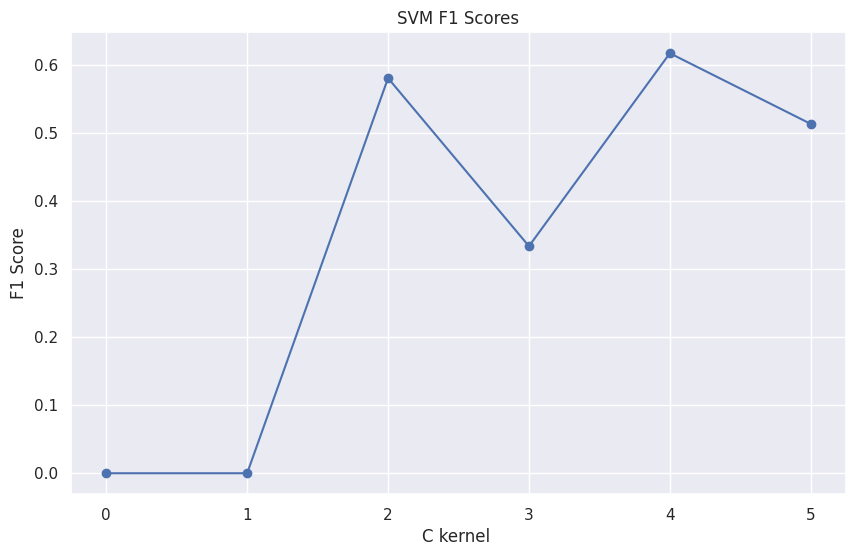

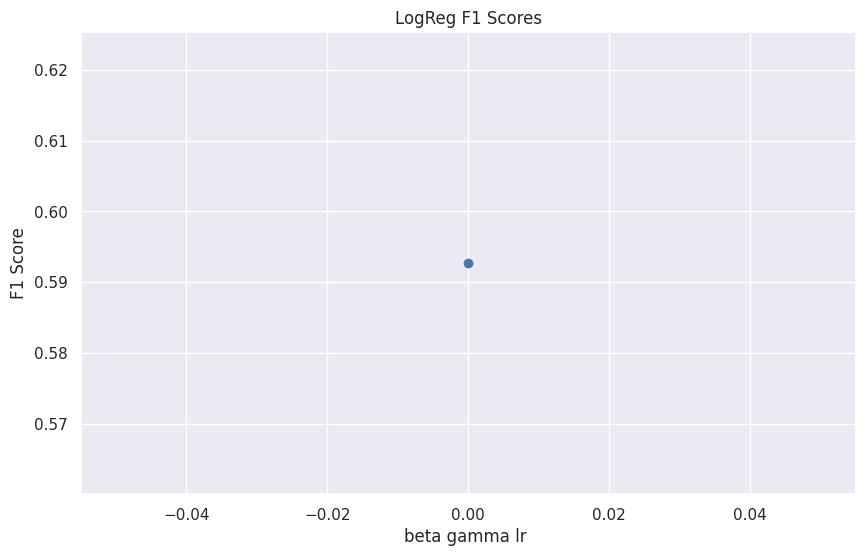

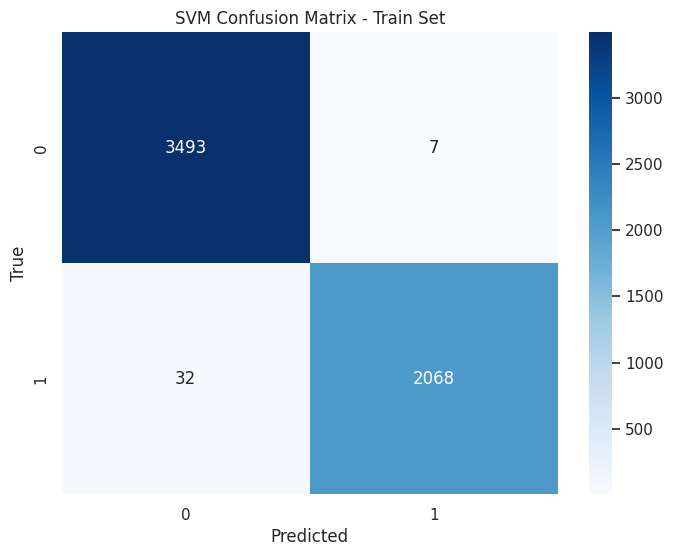

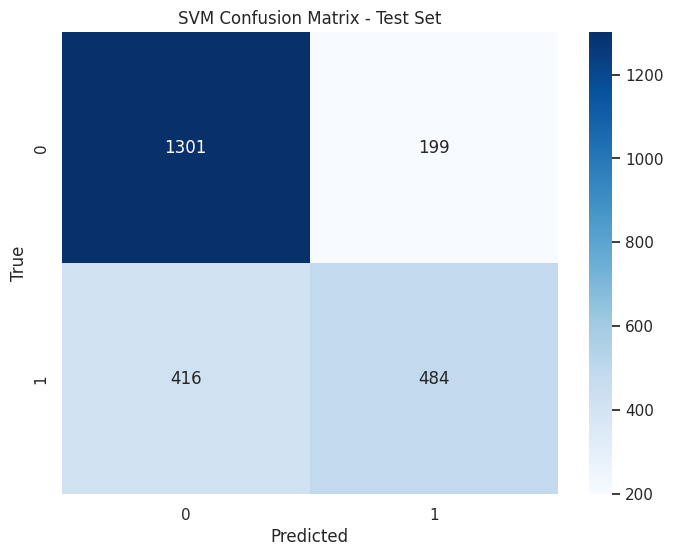

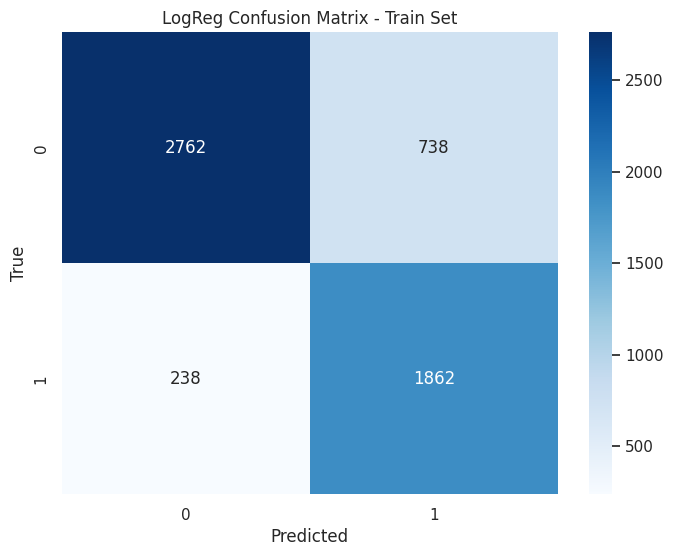

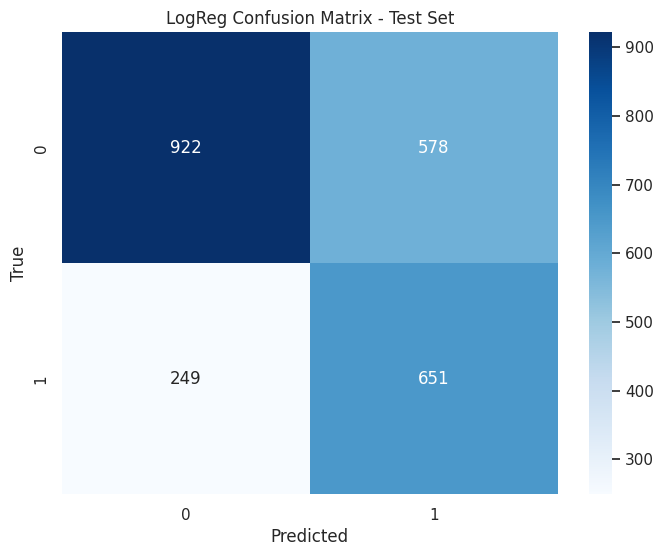

Classification Report for SVM:
              precision    recall  f1-score   support

           0       0.76      0.87      0.81      1500
           1       0.71      0.54      0.61       900

    accuracy                           0.74      2400
   macro avg       0.73      0.70      0.71      2400
weighted avg       0.74      0.74      0.73      2400

Classification Report for LogReg:
              precision    recall  f1-score   support

           0       0.79      0.61      0.69      1500
           1       0.53      0.72      0.61       900

    accuracy                           0.66      2400
   macro avg       0.66      0.67      0.65      2400
weighted avg       0.69      0.66      0.66      2400



In [ ]:
# Print best parameters
print("Best Parameters for SVM:", svm_grid_search.best_params_)
print("Best Parameters for Logit:", logit_grid_search.best_params_)

# Function to plot F1 scores for different parameter values
def plot_f1_scores(model, param_grid, title):
    param_values = param_grid.values()
    f1_scores = model.cv_results_['mean_test_score']

    plt.figure(figsize=(10, 6))
    plt.plot([i for i in range(len(f1_scores))], f1_scores, marker='o')
    plt.title(title)
    name = ""
    for i in list(param_grid.keys()):
      name += f'{i} '
    plt.xlabel(name)
    plt.ylabel('F1 Score')
    plt.grid(True)
    plt.show()


# Plot F1 scores for SVM
plot_f1_scores(svm_grid_search, svm_param_grid, "SVM F1 Scores")
plot_f1_scores(logit_grid_search, logit_param_grid, "LogReg F1 Scores")

# Function to plot confusion matrix
def plot_confusion_matrix(model, X, y, title):
    predictions = model.predict(X)
    cm = confusion_matrix(y, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
    plt.title(title)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

# Plot confusion matrix for models
plot_confusion_matrix(svm_grid_search, X_train, y_train, "SVM Confusion Matrix - Train Set")
plot_confusion_matrix(svm_grid_search, X_test, y_test, "SVM Confusion Matrix - Test Set")
plot_confusion_matrix(logit_grid_search, X_train.toarray(), y_train, "LogReg Confusion Matrix - Train Set")
plot_confusion_matrix(logit_grid_search, X_test.toarray(), y_test, "LogReg Confusion Matrix - Test Set")

# Evaluate models on the test set
svm_test_predictions = svm_grid_search.predict(X_test)
logit_test_predictions = logit_grid_search.predict(X_test.toarray())

# Print classification report for models
print("Classification Report for SVM:")
print(classification_report(y_test, svm_test_predictions))

print("Classification Report for LogReg:")
print(classification_report(y_test, logit_test_predictions))

### Анализ полученных результатов
Как мы видим лучшими были избраны следующие показатели для каждой из моделей соответственно:

Best Parameters for SVM: {'C': 10, 'kernel': 'linear'}

Best Parameters for Logit: {'beta': 0.5, 'gamma': 0.5, 'lr': 0.001}

Можно заметить, что в общем SVM показал более хорошие результаты, как на тестовой выборке, так и тренировочной(тут вообще почти не было ложных идентификаций), что можно видеть по confussion matrices, а также в статистике приведенной после них. Предположительно логит обучился не настолько хорошо, поскольку была недостаточная выборка или количество итераций, однако даже в таком виде обучение занимало очень значительное время, а при выборе большего количестве данных - не хватало ОЗУ в коллабе. Однако результат в 0.65 по метрике f1-score(macro avg) можно считать довольно неплохой с учетом того, что выборка была маленькой, а именно из 8000 векторизованных токенов, в то время как у SVM - 0.71, то есть разница не слишком разительная.